In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import flox
from flox.util import key_chain
from flox import geom

from ribflox.rep import State, RigidRepresentation, RigidTransform, AtomRepresentation

seed = 42
chain = key_chain(seed)

ROT_DIM = 4
POS_DIM = 3
AUX_DIM = 5

NUM_MOL = 16


def sample_state(key):
    chain = key_chain(key)
    s = State(
        jax.vmap(RigidRepresentation)(
            rot=jax.vmap(geom.unit)(jax.random.normal(next(chain), shape=(NUM_MOL, ROT_DIM,))),
            pos=jax.random.uniform(next(chain), shape=(NUM_MOL, POS_DIM,))
        ),
        aux=jax.random.normal(next(chain), shape=(NUM_MOL, AUX_DIM)),
        box=jnp.ones(3)
    )
    return s

s = jax.vmap(sample_state)(jax.random.split(next(chain), 128))


cpu


In [3]:
from functools import partial
from ribflox.flow import full_step, WrappedLens
from lenses import lens
from flox.flow import Transform, LayerStack
import equinox as eqx

LATENT = 32
HIDDEN = (128,)
CTRL_PTS = 13

NUM_LAYERS = 3

def initial_transform() -> Transform[State[AtomRepresentation], State[RigidRepresentation]]:
    return flox.flow.LensedTransform(
        RigidTransform(),
        WrappedLens(lens.mol),
        WrappedLens(lens.mol)
    )


make_layer = jax.tree_util.Partial(full_step, num_mol=NUM_MOL, num_auxiliaries=AUX_DIM, num_latent=LATENT, num_hidden=HIDDEN, num_ctrl_pts=CTRL_PTS)
stack = eqx.filter_vmap(make_layer)(
    jax.random.split(next(chain), NUM_LAYERS))

flow = flox.flow.Pipe[State[AtomRepresentation], State[RigidRepresentation]]([
    initial_transform(),
    LayerStack(stack)
])

In [4]:
from jax_dataclasses import pytree_dataclass

from flox.flow import Transformed

import numpy as np

KeyArray = jax.random.PRNGKeyArray | jnp.ndarray

@pytree_dataclass(frozen=True)
class Data:
    positions: jnp.ndarray
    box: jnp.ndarray
    energy: jnp.ndarray


# data = Data(**np.load("./data/water/data-iceIh_tip4pew-T270.npz"))
data = Data(**np.load("./data/water/md.npz"))
data = jax.tree_map(jnp.array, data)

def sample_state_from_data(key: KeyArray, data: Data) -> Transformed[State[AtomRepresentation]]:
    aux = jax.random.normal(next(chain), shape=(NUM_MOL, AUX_DIM,))
    return Transformed(State(
        mol=data.positions.reshape(NUM_MOL, 4, 3),
        aux=aux,
        box=data.box
    ), data.energy)

data;

In [5]:
data.positions.reshape(-1, 16, 4, 3).shape

(50000, 16, 4, 3)

In [6]:
# jax.vmap(sample_state_from_data)(jax.random.split(next(chain), data.positions.shape[0]), data).aux.shape

In [7]:
# for i, key in zip(range(1), key_chain(seed)):
#     flow.forward(sample_state_from_data(key, data).obj)

In [8]:



# s = State(
#     mol=jax.random.normal(next(chain), (NUM_MOL, 4, 3,)),
#     aux=jax.random.normal(next(chain), shape=(NUM_MOL, AUX_DIM)),
#     box=jnp.ones(3)
# )

@jax.jit
def foo(s):
    s_, _ = jax.vmap(flow.inverse)(s)
    # s_, _ = unpack(flow.forward(s))
    return s_

In [9]:
from flox._src.util.misc import unpack

s = jax.vmap(initial_transform().inverse)(s)
s_, _ = unpack(eqx.filter_jit(eqx.filter_vmap(flow.forward))(s.obj))

In [10]:
# foo(s)

In [12]:
from jaxtyping import Float, Array  # type: ignore

from flox.nn import train
from flox.flow import DatasetSampler


Scalar = Float[Array, ""] | float

def base_potential(inp: State[RigidRepresentation]) -> Scalar:
    return jnp.sum(0.5 * jnp.square(inp.aux))

def sample_data(key: KeyArray) -> Transformed[State[AtomRepresentation]]:
    chain = key_chain(key)
    idx = jax.random.randint(next(chain), (), 0, 50_000)
    sample = jax.tree_map(lambda x: x[idx], data)
    return sample_state_from_data(next(chain), sample)
        
# step = train.mle_step(base_potential, optim, sample_data, 128)
step = train.free_energy_step(base_potential, optim, sample_data, 128)

In [13]:
chain = key_chain(42)

In [14]:
key = next(chain)
loss, flow, opt_state = step(key, flow, opt_state)

In [17]:
chain = key_chain(42)

from typing import Protocol, TypeVar, cast
import optax

NUM_ITERS = 3_000
PLOT_INTERVAL = 50
LEARNING_RATE = 1e-4

optim = optax.adam(learning_rate=LEARNING_RATE)

T = TypeVar("T")
S = TypeVar("S")
class Model(Transform[T, S], Protocol[T, S]):
    ...

params, static = cast(tuple[Model[State[AtomRepresentation], State[RigidRepresentation]], ...], eqx.partition(flow, eqx.is_array))
opt_state = optim.init(params)  # type: ignore

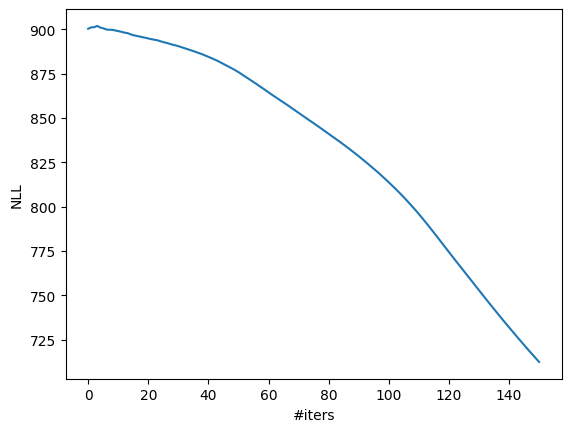

loss: 639.0:   7%|▋         | 198/3000 [01:16<18:03,  2.59it/s]


KeyboardInterrupt: 

In [18]:
import time

from IPython import display  # type: ignore
from IPython.display import clear_output  # type: ignore

import matplotlib.pyplot as plt
from tqdm import tqdm

pbar = tqdm(range(NUM_ITERS))
agg_loss = train.RunningMean(0., 0)
losses = []


for i in pbar:
    
    key = next(chain)
    loss, flow, opt_state = step(key, flow, opt_state)
    # loss, flow, opt_state = step(key, flow, opt_state)  # type: ignore
    agg_loss = agg_loss.update(loss)
    losses.append(agg_loss.value)
    
    pbar.set_description(f"loss: {agg_loss.value:.4}")
    if not i % PLOT_INTERVAL:
        
        display.clear_output(wait=True)
        plt.plot(losses)
        plt.ylabel("NLL")
        plt.xlabel("#iters")
    
        plt.show()
        time.sleep(0.001)